# Medical Transcriptions Categorization
Freya Gray
CS39AA - Natural Language Processing
<br>
This project uses medical transcripts to try and classify the medical specialty that the transcript originated from. The dataset is from the Medical Transcriptions dataset on [Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions). 
This notebook will implement a baseline model for the classification problem

## Imports

In [222]:
import pandas as pd 
import spacy
import seaborn as sn
import string
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

## Dataset

In [203]:
df = pd.read_csv('mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Clean Dataset

Remove nonessential columns and drop null entries

In [204]:
df.drop(['Unnamed: 0','description','sample_name'], axis = 1, inplace = True)
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.describe()

,medical_specialty,transcription,keywords
count,3898,3898,3898
unique,39,1860,3816
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",
freq,1021,5,81


Drop medical specialties that have less than 50 entries

In [205]:
value_counts = df.medical_specialty.value_counts()
remove = value_counts[value_counts <= 50].index
df = df[~df.medical_specialty.isin(remove)]
df = df.reset_index(drop=True)

In [206]:
df.head()

,medical_specialty,transcription,keywords
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler..."


In [207]:
df.describe()

,medical_specialty,transcription,keywords
count,3514,3514,3514
unique,18,1836,3444
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",
freq,1021,5,69


In [208]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
df['labels'] = Encoder.fit_transform(df['medical_specialty'])
df.head()

,medical_specialty,transcription,keywords,labels
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",0
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",0
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...",0
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...",0
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...",0


## Pipeline

### Text Cleaning

In [210]:
nlp = spacy.load('en_core_web_lg')

from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)
import string
punct=string.punctuation

def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens
#Source: Medium

### Create Train and Test Sets

In [211]:
x_train, x_test, y_train, y_test = train_test_split(df['transcription'], df['labels'],test_size=0.2)

In [212]:
x_train

1312    INDICATION:,  Prostate Cancer.,TECHNIQUE:,  3....
1269    SUBJECTIVE:,  This is a 38-year-old female who...
287     PREOPERATIVE DIAGNOSES:,1.  Need for intraveno...
1300    DIAGNOSIS: , Left breast adenocarcinoma stage ...
2368    CC:, Fluctuating level of consciousness.,HX:, ...
                              ...                        
430     PREOPERATIVE DIAGNOSIS: , Phimosis.,POSTOPERAT...
169     PREOPERATIVE DIAGNOSIS:,  Vitreous hemorrhage,...
1713    CC:, BLE weakness.,HX:, This 82y/o RHM was ref...
164     PREOPERATIVE DIAGNOSIS: , Chronic venous hyper...
1162    PREOPERATIVE DIAGNOSIS: , Achilles tendon rupt...
Name: transcription, Length: 2811, dtype: object

### Pipeline parameters

In [213]:
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
classifier = svm.SVC()

In [214]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

## Model

Set grid search parameters

In [215]:
param_grid={'clf__C': [1, 10], 'clf__kernel': ('linear', 'rbf')}

In [216]:
grid = GridSearchCV(clf, cv = 3, param_grid=param_grid, n_jobs = -1)

In [217]:
grid.fit(x_train,y_train)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
y_pred = grid.predict(x_test)

Best parameter (CV score=0.295):
{'clf__C': 1, 'clf__kernel': 'linear'}


## Confusion Matrix

In [218]:
conf_mat = confusion_matrix(y_test,y_pred)

In [219]:
accuracy =  accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred, average='weighted',zero_division = 0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [220]:
conf_labels = [' Cardiovascular / Pulmonary',' Consult - History and Phy.',
              ' Discharge Summary',' ENT - Otolaryngology',
              ' Gastroenterology',' General Medicine',
              ' Hematology - Oncology',' Nephrology', 
              ' Neurology',' Neurosurgery', 
              ' Obstetrics / Gynecology',' Ophthalmology',
              ' Orthopedic',' Pain Management',
              ' Radiology', ' SOAP / Chart / Progress Notes',
              ' Surgery',' Urology']

<function matplotlib.pyplot.show(close=None, block=None)>

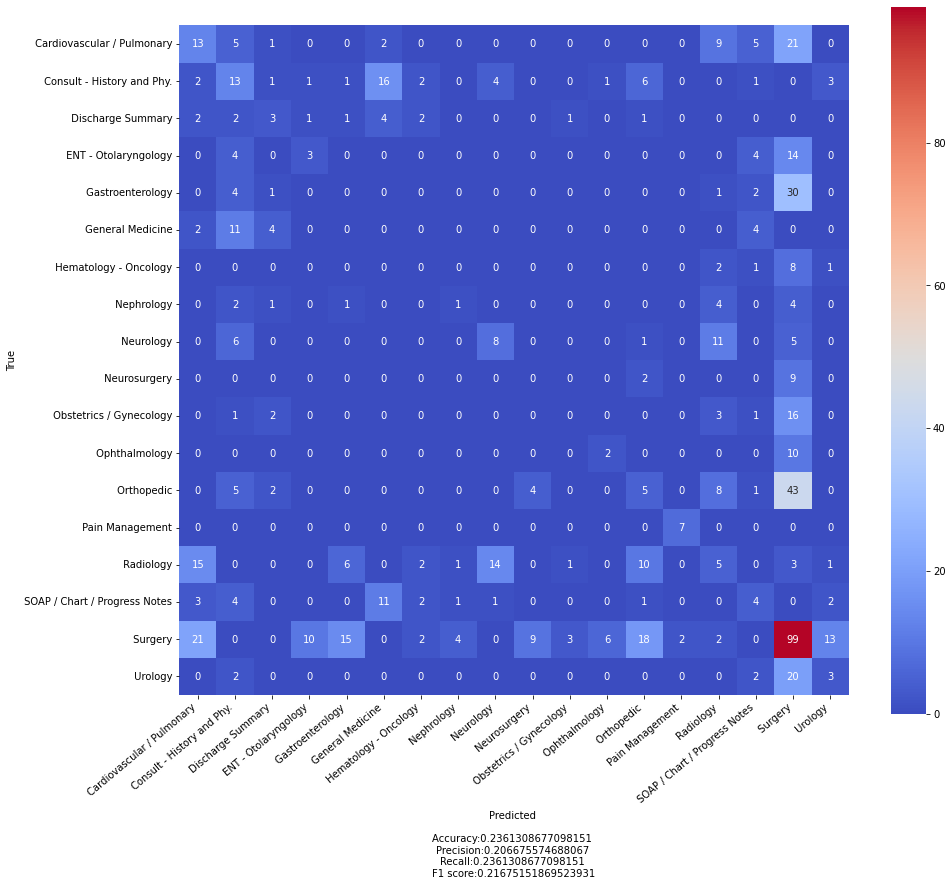

In [221]:
metrics = 'Predicted \n\nAccuracy:{} \nPrecision:{} \nRecall:{} \nF1 score:{}'.format(accuracy, precision, recall, f1)
plt.figure(figsize=(15,13))
matrix = sn.heatmap(conf_mat, annot = True, fmt = 'd', cmap = 'coolwarm', square = True, xticklabels = conf_labels, yticklabels = conf_labels) 
matrix.set_xticklabels(matrix.get_xticklabels(), rotation=40, ha="right")
matrix.set(xlabel = metrics, ylabel = 'True')
plt.show

# Sources

**Dataset:**<br/>
[Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions)<br/>
**Guide for Text Cleaning:** <br/>
[Medium](https://medium.com/@sourenh94/tweets-sentiment-analysis-using-deep-transfer-learning-6cab7009986f)